In [5]:
import jax
from jax import lax, jit, grad
import jax.numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state
import  haiku as hk
import optax
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import functools
from typing import Any, Callable, Sequence, Optional
import numpy as np
import matplotlib.pyplot as plt

#### FLAX
- NN library built on top of JAX by Google Research Team
- Designed for flexibility (Flexibility + JAX -> FLAX)<br>

#### Haiku
- Not Learning that here
- DeepMind's NN JAX Library<br>

#### Optax
- JAX Optimizers
- Also developed by DeepMind

#### Let's start with the simplest model possible - A Single Feed-forward Layer (Linear Regression)

In [6]:
model = nn.Dense(features=5)

# All of Flax NN Layers inherit from Module Class (similar to PyTorch)
print(nn.Dense.__bases__)

(<class 'flax.linen.module.Module'>,)


#### Step 1: Initialize

In [7]:
seed = 23
key1, key2 = jax.random.split(jax.random.PRNGKey(seed))
x = jax.random.normal(key1, (10,))      # Create a dummy input


# Initialization Call - to get actual model weights
y, params = model.init_with_output(key2, x)
print(y)
print(jax.tree.map(lambda x: x.shape, params))

[ 0.47637334  0.15484172  0.2964747   0.2194426  -0.13082546]
{'params': {'bias': (5,), 'kernel': (10, 5)}}


params is a "FrozenDict" here - again not mutable

#### Step 2: Apply

In [8]:
y = model.apply(params, x)
# This is how you run prediction in Flax
print(y)

[ 0.47637334  0.15484172  0.2964747   0.2194426  -0.13082546]


In [9]:
try:
    y = model(x)        # PyTorch Syntax does not work
except Exception as e:
    print(e)

Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.CallCompactUnboundModuleError)


#### Let's compare with Haiku

In [10]:
# All modules in Haiku must be initialized inside and haiku.transform
model = hk.transform(lambda x: hk.Linear(5)(x))

In [11]:
seed = 23
key1, key2 = jax.random.split(jax.random.PRNGKey(seed))
x = jax.random.normal(key1, (10,))

In [12]:
params = model.init(key2, x)
y = model.apply(params, None, x)
print(y)

[-0.29048687  0.9906897   1.4123361  -0.80964214  0.38544467]


In [13]:
print(hk.Linear.__bases__)

(<class 'haiku._src.module.Module'>,)


#### Let's train a simple Linear Regression Model

In [22]:
n_samples = 150
x_dim = 2  # putting small numbers here so that we can visualize the data easily
y_dim = 1
noise_amplitude = 0.1

# Generate (random) ground truth W and b
# Note: we could get W, b from a randomely initialized nn.Dense here, being closer to JAX for now 
key, w_key, b_key = jax.random.split(jax.random.PRNGKey(seed), num=3)
W = jax.random.normal(w_key, (x_dim, y_dim))  # weight
b = jax.random.normal(b_key, (y_dim,))  # bias

# This is the structure that Flax expects (recall from the previous section!)
true_params = freeze({'params': {'bias': b, 'kernel': W}})

# Generate samples with additional noise
key, x_key, noise_key = jax.random.split(key, num=3)
xs = jax.random.normal(x_key, (n_samples, x_dim))
ys = jnp.dot(xs, W) + b
ys += noise_amplitude * jax.random.normal(noise_key, (n_samples, y_dim))
print(f'xs shape = {xs.shape} ; ys shape = {ys.shape}')

xs shape = (150, 2) ; ys shape = (150, 1)


#### Let's visualize our data

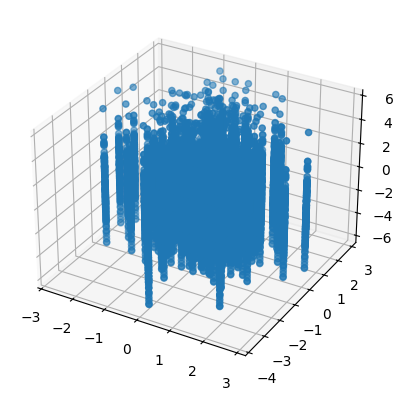

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
assert xs.shape[-1] == 2 and ys.shape[-1] == 1  # low dimensional data so that we can plot it
ax.scatter(xs[:, 0], xs[:, 1], zs=ys)

In [24]:
def make_mse_loss(xs, ys):
    
    def mse_loss(params):
        """Gives the value of the loss on the (xs, ys) dataset for the given model (params)."""
        
        # Define the squared loss for a single pair (x,y)
        def squared_error(x, y):
            pred = model.apply(params, x)
            # Inner because 'y' could have in general more than 1 dims
            return jnp.inner(y-pred, y-pred) / 2.0

        # Batched version via vmap
        return jnp.mean(jax.vmap(squared_error)(xs, ys), axis=0)

    return jax.jit(mse_loss)  # and finally we jit the result (mse_loss is a pure function)

mse_loss = make_mse_loss(xs, ys)
value_and_grad_fn = jax.value_and_grad(mse_loss)

In [26]:
# Let's reuse the simple feed-forward layer since it trivially implements linear regression
model = nn.Dense(features=y_dim)
params = model.init(key, xs)
print(f'Initial params = {params}')

# Let's set some reasonable hyperparams
lr = 0.3
epochs = 20
log_period_epoch = 5

print('-' * 50)
for epoch in range(epochs):
    loss, grads = value_and_grad_fn(params)
    # SGD (closer to JAX again, but we'll progressively go towards how stuff is done in Flax)
    params = jax.tree.map(lambda p, g: p - lr * g, params, grads)

    if epoch % log_period_epoch == 0:
        print(f'epoch {epoch}, loss = {loss}')

print('-' * 50)
print(f'Learned params = {params}')
print(f'Gt params = {true_params}')

Initial params = {'params': {'kernel': Array([[-0.9901299 ],
       [-0.50967383]], dtype=float32), 'bias': Array([0.], dtype=float32)}}
--------------------------------------------------
epoch 0, loss = 1.4187357425689697
epoch 5, loss = 0.02906985580921173
epoch 10, loss = 0.004749846179038286
epoch 15, loss = 0.004193232860416174
--------------------------------------------------
Learned params = {'params': {'bias': Array([-0.89052135], dtype=float32), 'kernel': Array([[-0.7659607],
       [-1.8077115]], dtype=float32)}}
Gt params = FrozenDict({
    params: {
        bias: Array([-0.88823646], dtype=float32),
        kernel: Array([[-0.7596356],
               [-1.8050936]], dtype=float32),
    },
})


#### Let's do the same thing but with dedicated Optimizers!<br>

i.e Using Optax!

In [27]:
opt_sgd = optax.sgd(learning_rate=lr)
opt_state = opt_sgd.init(params)  # always the same pattern - handling state externally
print(opt_state)

(EmptyState(), EmptyState())


In [28]:
params = model.init(key, xs)  # let's start with fresh params again

for epoch in range(epochs):
    loss, grads = value_and_grad_fn(params)
    updates, opt_state = opt_sgd.update(grads, opt_state)  # arbitrary optim logic!
    params = optax.apply_updates(params, updates)

    if epoch % log_period_epoch == 0:
        print(f'epoch {epoch}, loss = {loss}')

# Note 1: as expected we get the same loss values
# Note 2: we'll later see more concise ways to handle all of these state components (hint: TrainState)

epoch 0, loss = 1.4187357425689697
epoch 5, loss = 0.02906985580921173
epoch 10, loss = 0.004749846179038286
epoch 15, loss = 0.004193232860416174


#### Creating Custom Models

In [32]:
class MLP(nn.Module):
    num_neurons_per_layer: Sequence[int]  # data field (nn.Module is Python's dataclass)

    def setup(self):  # because dataclass is implicitly using the  __init__ function... :')
        self.layers = [nn.Dense(n) for n in self.num_neurons_per_layer]

    def __call__(self, x):
        activation = x
        for i, layer in enumerate(self.layers):
            activation = layer(activation)
            if i != len(self.layers) - 1:
                activation = nn.relu(activation)
        return activation

x_key, init_key = jax.random.split(jax.random.PRNGKey(seed))

model = MLP(num_neurons_per_layer=[16, 8, 1])  # define an MLP model
x = jax.random.uniform(x_key, (4,4))  # dummy input
params = model.init(init_key, x)  # initialize via init
y = model.apply(params, x)  # do a forward pass via apply

print(jax.tree.map(jnp.shape, params))
print(f'Output: {y}')

{'params': {'layers_0': {'bias': (16,), 'kernel': (4, 16)}, 'layers_1': {'bias': (8,), 'kernel': (16, 8)}, 'layers_2': {'bias': (1,), 'kernel': (8, 1)}}}
Output: [[0.35756692]
 [0.37379223]
 [0.07459793]
 [0.3166891 ]]


Great! 

Now we know how to build more complex models let's dive deeper and understand how the 'nn.Dense' module is designed itself.

#### Introducing param

In [35]:
class MyDenseImp(nn.Module):
    num_neurons: int
    weight_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight',  # parametar name (as it will appear in the FrozenDict)
                self.weight_init,  # initialization function, RNG passed implicitly through init fn
                (x.shape[-1], self.num_neurons))  # shape info
        bias = self.param('bias', self.bias_init, (self.num_neurons,))

        return jnp.dot(x, weight)  + bias

x_key, init_key = jax.random.split(jax.random.PRNGKey(seed))

model = MyDenseImp(num_neurons=3)  # initialize the model
x = jax.random.uniform(x_key, (4,4))  # dummy input
params = model.init(init_key, x)  # initialize via init
y = model.apply(params, x)  # do a forward pass via apply

print(jax.tree.map(jnp.shape, params))
print(f'Output: {y}')

{'params': {'bias': (3,), 'weight': (4, 3)}}
Output: [[ 0.18654615 -0.9421387  -1.0624766 ]
 [ 0.547995   -0.7331487  -0.7501927 ]
 [ 0.3120832   0.14876933 -1.0756196 ]
 [ 0.00147474 -0.63348615 -0.8141961 ]]


So far we've only seen trainable params.<br><br>

ML models often times have variables which are part of the state but are not optimized via gradient descent.<br><br>

Let's see how we can handle them using a simple (and contrived) example!

#### Introducing variable

Note on terminology: variable is a broader term and it includes both params (trainable variables) as well as non-trainable vars.

In [36]:
class BiasAdderWithRunningMean(nn.Module):
    decay: float = 0.99

    @nn.compact
    def __call__(self, x):
        is_initialized = self.has_variable('batch_stats', 'ema')

        # 'batch_stats' is not an arbitrary name!
        # Flax uses that name in its implementation of BatchNorm (hard-coded, probably not the best of designs?)
        ema = self.variable('batch_stats', 'ema', lambda shape: jnp.zeros(shape), x.shape[1:])

        # self.param will by default add this variable to 'params' collection (vs 'batch_stats' above)
        # Again some idiosyncrasies here we need to pass a key even though we don't actually use it...
        bias = self.param('bias', lambda key, shape: jnp.zeros(shape), x.shape[1:])

        if is_initialized:
            # self.variable returns a reference hence .value
            ema.value = self.decay * ema.value + (1.0 - self.decay) * jnp.mean(x, axis=0, keepdims=True)

        return x - ema.value + bias

x_key, init_key = jax.random.split(jax.random.PRNGKey(seed))

model = BiasAdderWithRunningMean()
x = jax.random.uniform(x_key, (10,4))  # dummy input
variables = model.init(init_key, x)
print(f'Multiple collections = {variables}')  # we can now see a new collection 'batch_stats'

# We have to use mutable since regular params are not modified during the forward
# pass, but these variables are. We can't keep state internally (because JAX) so we have to return it.
y, updated_non_trainable_params = model.apply(variables, x, mutable=['batch_stats'])
print(updated_non_trainable_params)

Multiple collections = {'batch_stats': {'ema': Array([0., 0., 0., 0.], dtype=float32)}, 'params': {'bias': Array([0., 0., 0., 0.], dtype=float32)}}
{'batch_stats': {'ema': Array([[0.00563165, 0.00538991, 0.00534612, 0.00525282]], dtype=float32)}}


In [38]:
# Let's see how we could train such model!
def update_step(opt, apply_fn, x, opt_state, params, non_trainable_params):

    def loss_fn(params):
        y, updated_non_trainable_params = apply_fn(
            {'params': params, **non_trainable_params}, 
            x, mutable=list(non_trainable_params.keys()))
        
        loss = ((x - y) ** 2).sum()  # not doing anything really, just for the demo purpose

        return loss, updated_non_trainable_params

    (loss, non_trainable_params), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return opt_state, params, non_trainable_params  # all of these represent the state - ugly, for now

model = BiasAdderWithRunningMean()
x = jnp.ones((10,4))  # dummy input, using ones because it's easier to see what's going on

variables = model.init(jax.random.PRNGKey(seed), x)
non_trainable_params, params = variables.pop('params')
del variables  # delete variables to avoid wasting resources (this pattern is used in the official code)

sgd_opt = optax.sgd(learning_rate=0.1)  # originally you'll see them use the 'tx' naming (from opTaX)
opt_state = sgd_opt.init(params)

for _ in range(3):
    # We'll later see how TrainState abstraction will make this step much more elegant!
    opt_state, params, non_trainable_params = update_step(sgd_opt, model.apply, x, opt_state, params, non_trainable_params)
    print(non_trainable_params)

ValueError: not enough values to unpack (expected 2, got 1)

Let's go a level up in abstraction again now that we understand params and variables!<br><br>

Certain layers like BatchNorm will use variables in the background.<br><br>

Let's see a last example that is conceptually as complicated as it gets when it comes to Flax's idiosyncrasies, and high-level at the same time.

In [39]:
class DDNBlock(nn.Module):
    """Dense, dropout + batchnorm combo.

    Contains trainable variables (params), non-trainable variables (batch stats),
    and stochasticity in the forward pass (because of dropout).
    """
    num_neurons: int
    training: bool

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.num_neurons)(x)
        x = nn.Dropout(rate=0.5, deterministic=not self.training)(x)
        x = nn.BatchNorm(use_running_average=not self.training)(x)
        return x

key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(seed), 4)

model = DDNBlock(num_neurons=3, training=True)
x = jax.random.uniform(key1, (3,4,4))

# New: because of Dropout we now have to include its unique key - kinda weird, but you get used to it
variables = model.init({'params': key2, 'dropout': key3}, x)
print(variables)

# And same here, everything else remains the same as the previous example
y, non_trainable_params = model.apply(variables, x, rngs={'dropout': key4}, mutable=['batch_stats'])

# Let's run these model variables during "evaluation":
eval_model = DDNBlock(num_neurons=3, training=False)
# Because training=False we don't have stochasticity in the forward pass neither do we update the stats
y = eval_model.apply(variables, x)

{'params': {'Dense_0': {'kernel': Array([[ 0.41116053, -0.6688684 ,  0.845223  ],
       [ 0.09425288, -0.32594317, -0.90455365],
       [-0.4227396 , -0.3884118 ,  0.0389565 ],
       [-0.9543954 , -0.16793758,  0.9900657 ]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}, 'BatchNorm_0': {'scale': Array([1., 1., 1.], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}}, 'batch_stats': {'BatchNorm_0': {'mean': Array([0., 0., 0.], dtype=float32), 'var': Array([1., 1., 1.], dtype=float32)}}}
